# HD106315

**Note**: There are two transiting planets around this target, we are looking at planet c. Here we assume there are no transits of b, but I haven't actually checked.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.io import fits
import astropy.units as u

In [3]:
name = 'HD106315'

In [4]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))
fnames = np.sort(fnames)

In [18]:
obs = om.Observation.from_files(fnames, planet_letter='c')

In [19]:
obs

HD-106315 [8 Visits]

In [20]:
clc = lk.search_lightcurve(name, mission='K2', author='EVEREST').download()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux.value * u.electron/u.s
clc = clc.flatten(51)
clc = clc[clc.flux.value > 0.97]
clc = clc.remove_outliers(sigma_upper=3, sigma_lower=1e2)

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

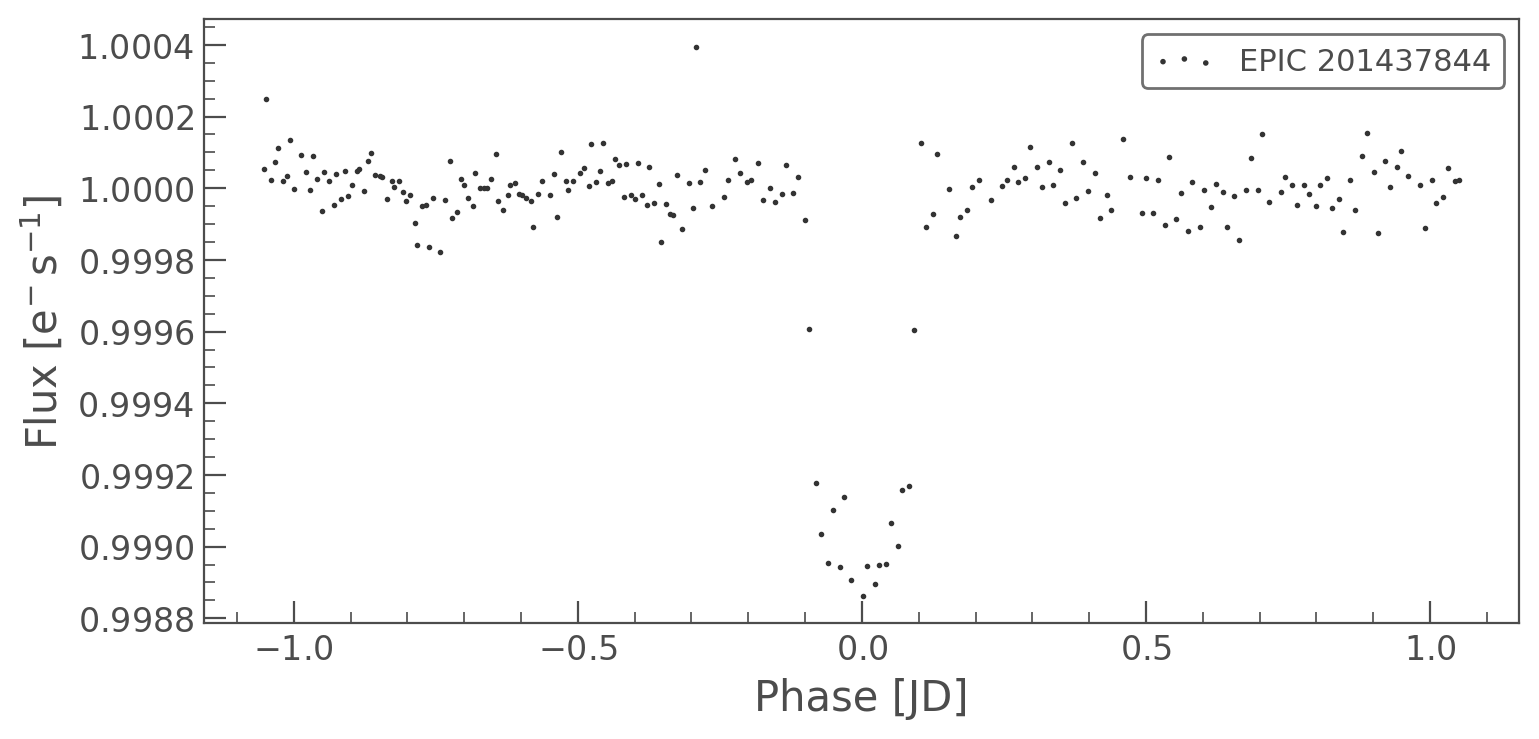

In [21]:
k = np.abs(((clc.time.value - (obs.t0 - 2454833 + obs.period/2))/obs.period) % 1 - 0.5) < 0.05
clc[k].fold(obs.period, obs.t0 - 2454833).scatter()

In [22]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2454833,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)))

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

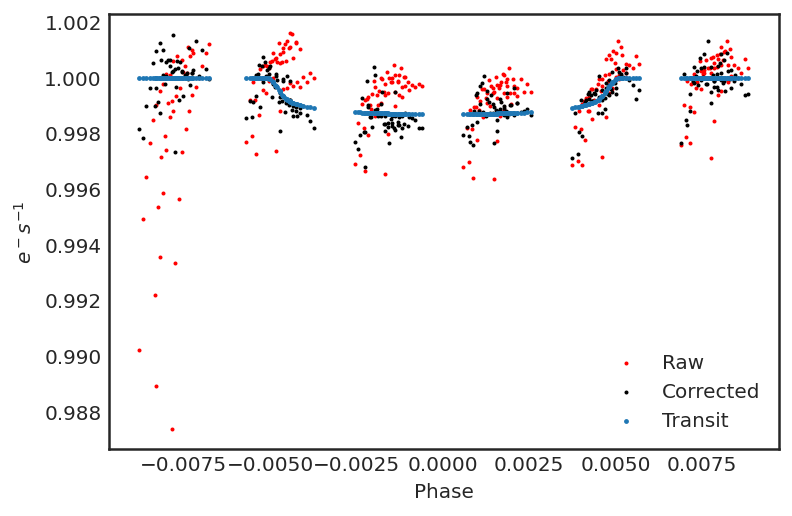

In [23]:
obs.plot()

In [25]:
obs.fit_model()

Fitting Transit/Eclipse Model: 100%|██████████████| 8/8 [03:02<00:00, 22.78s/it]


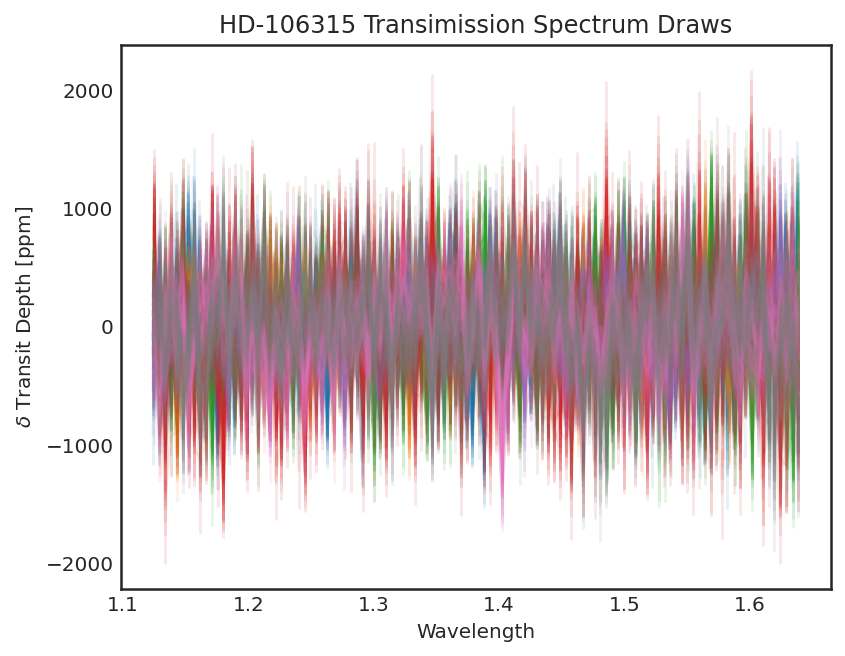

In [26]:
obs.plot_spectra()

<AxesSubplot:title={'center':'HD-106315 Transmission Spectrum, Visit: 2'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

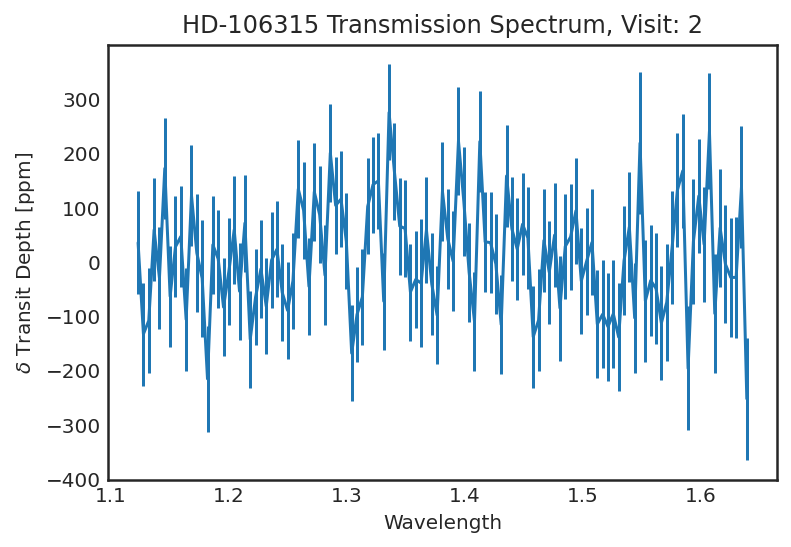

In [27]:
om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 200)).plot()

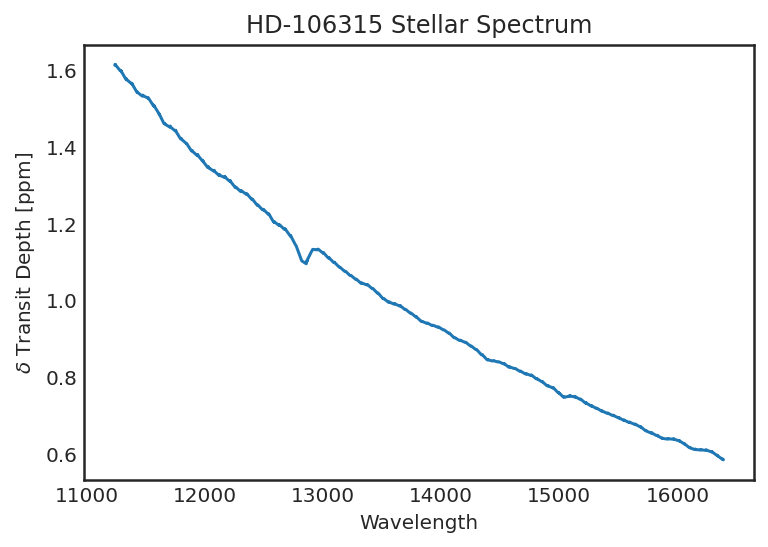

In [28]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

In [29]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits', overwrite=True)
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits', overwrite=True)
except:
    pass

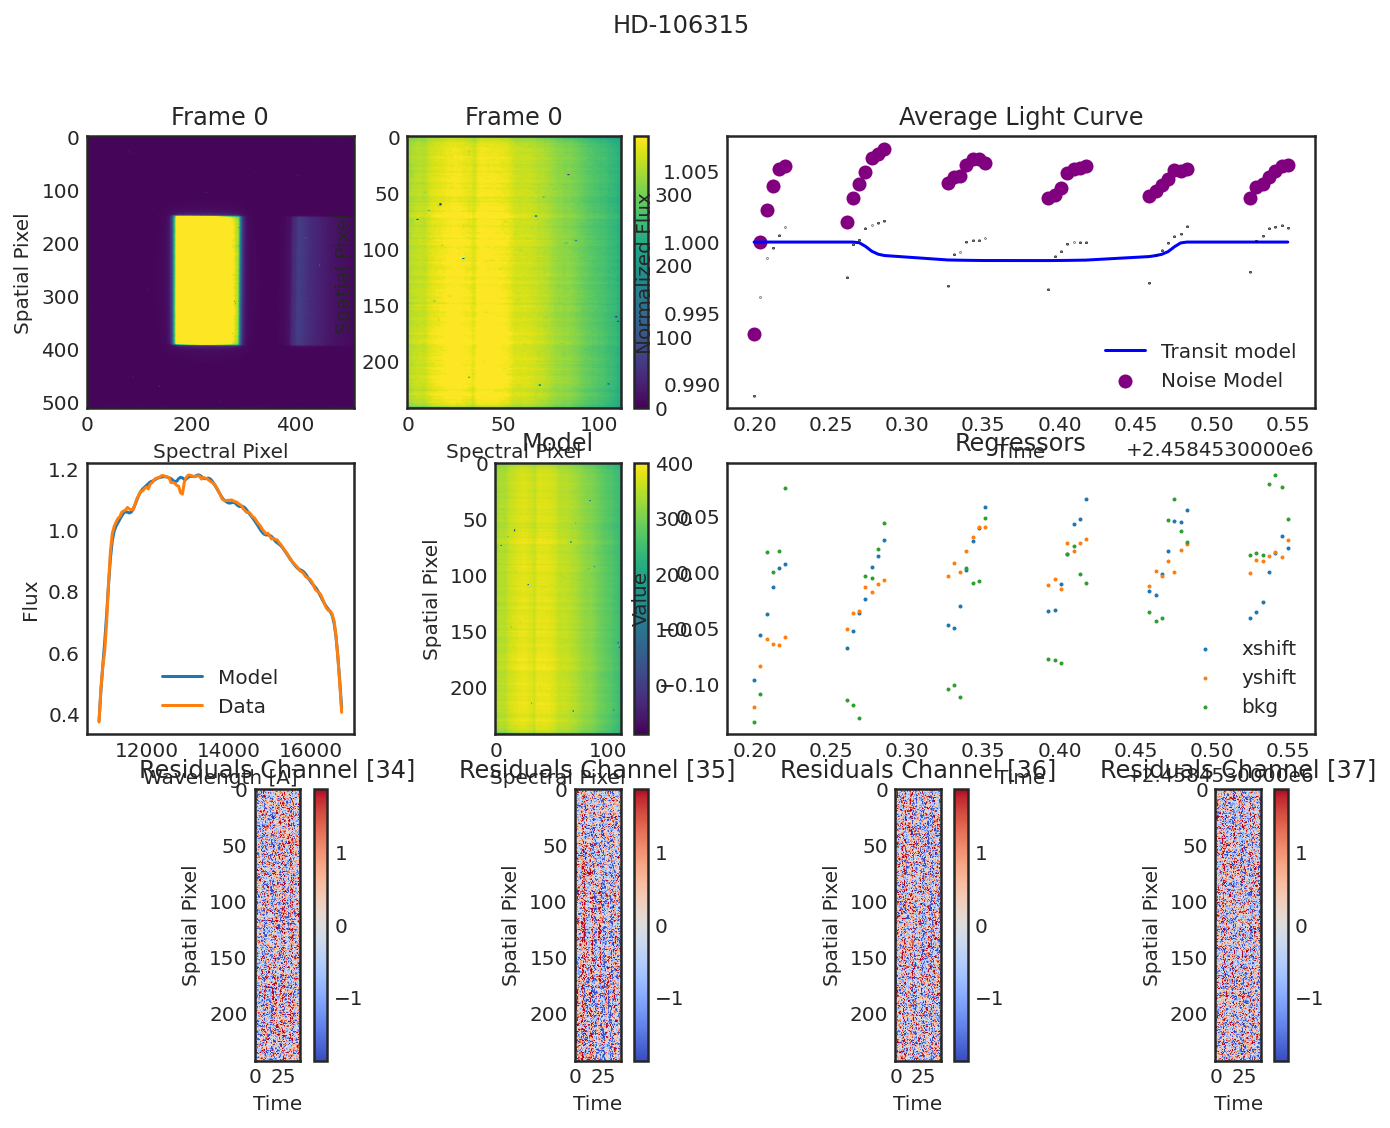

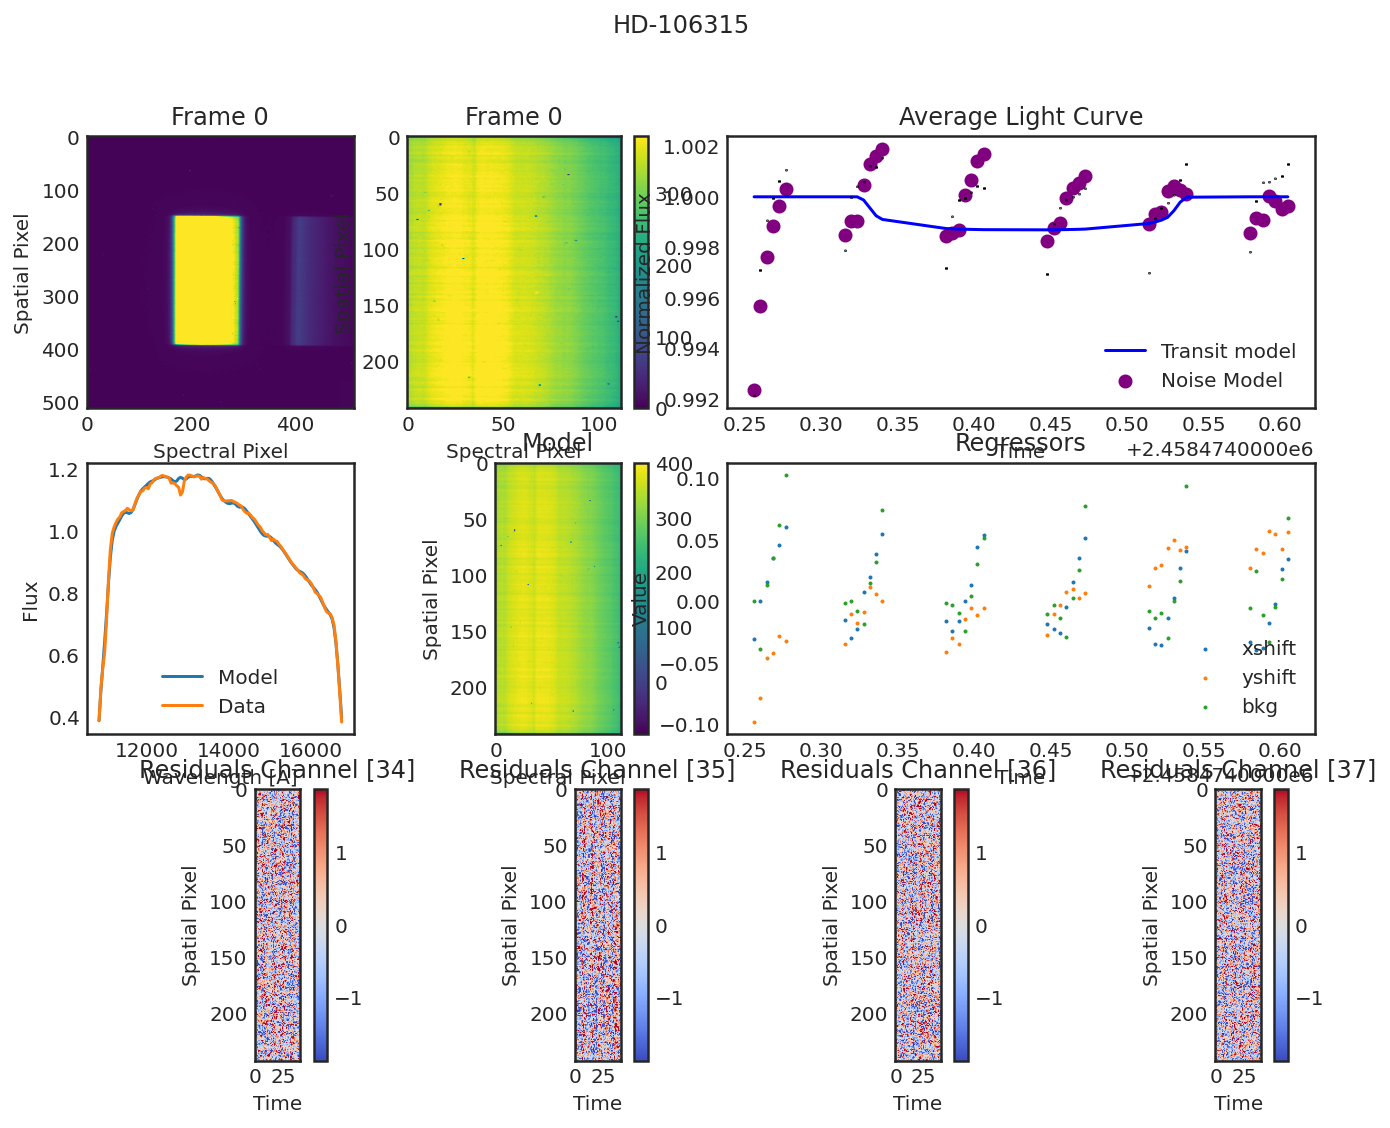

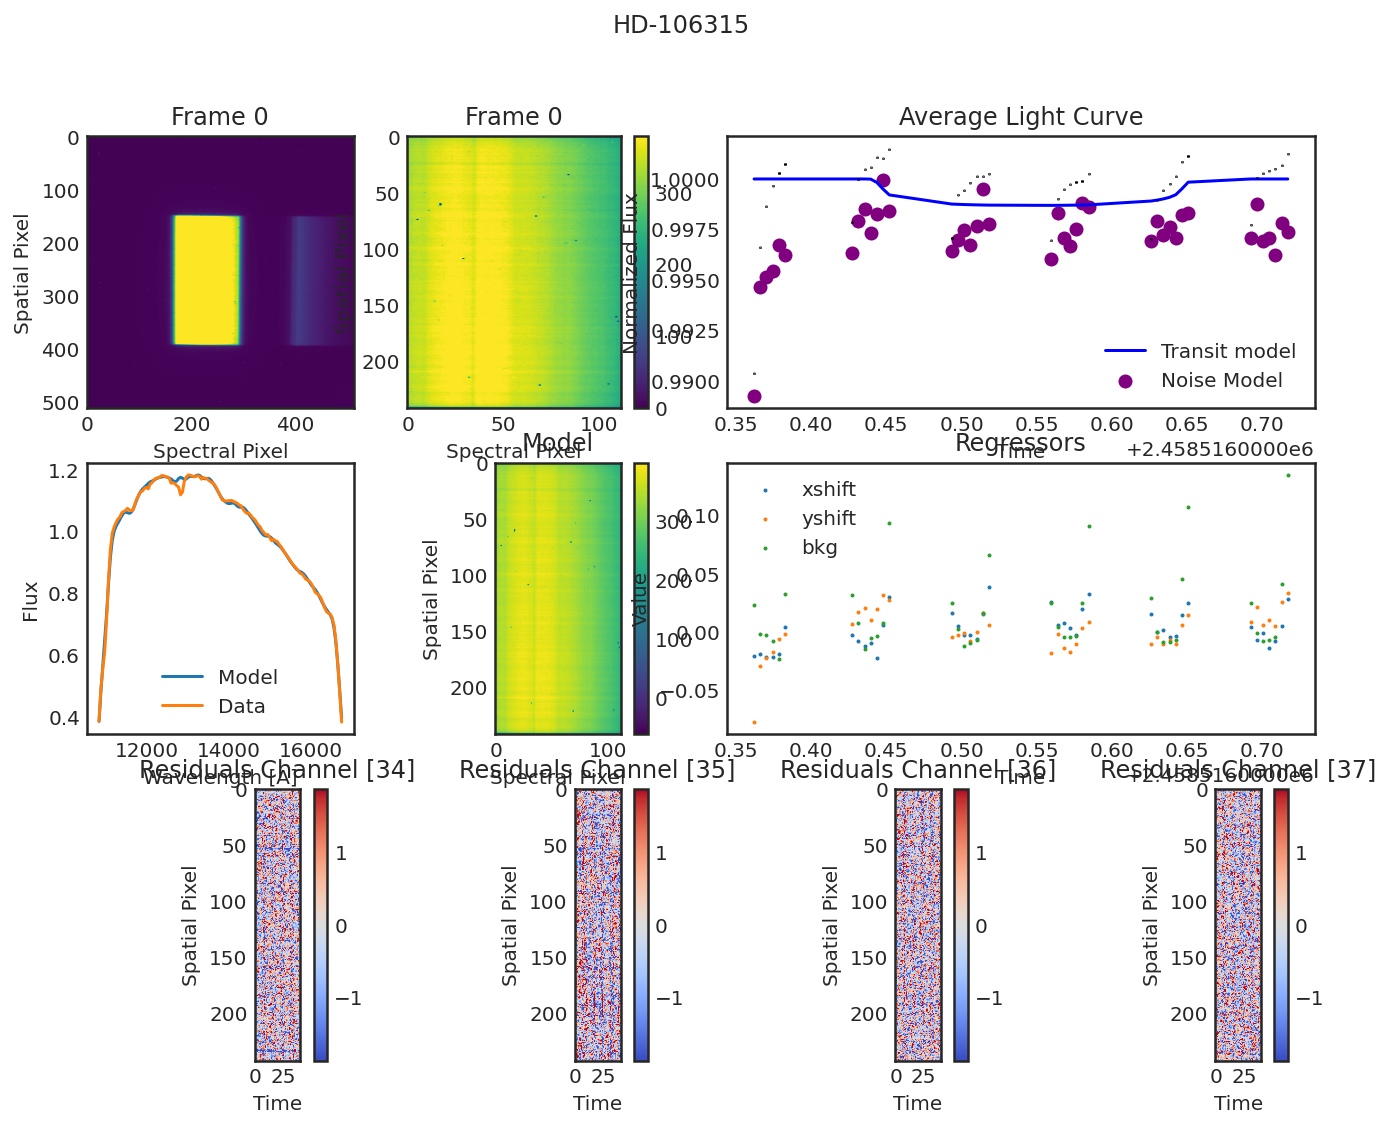

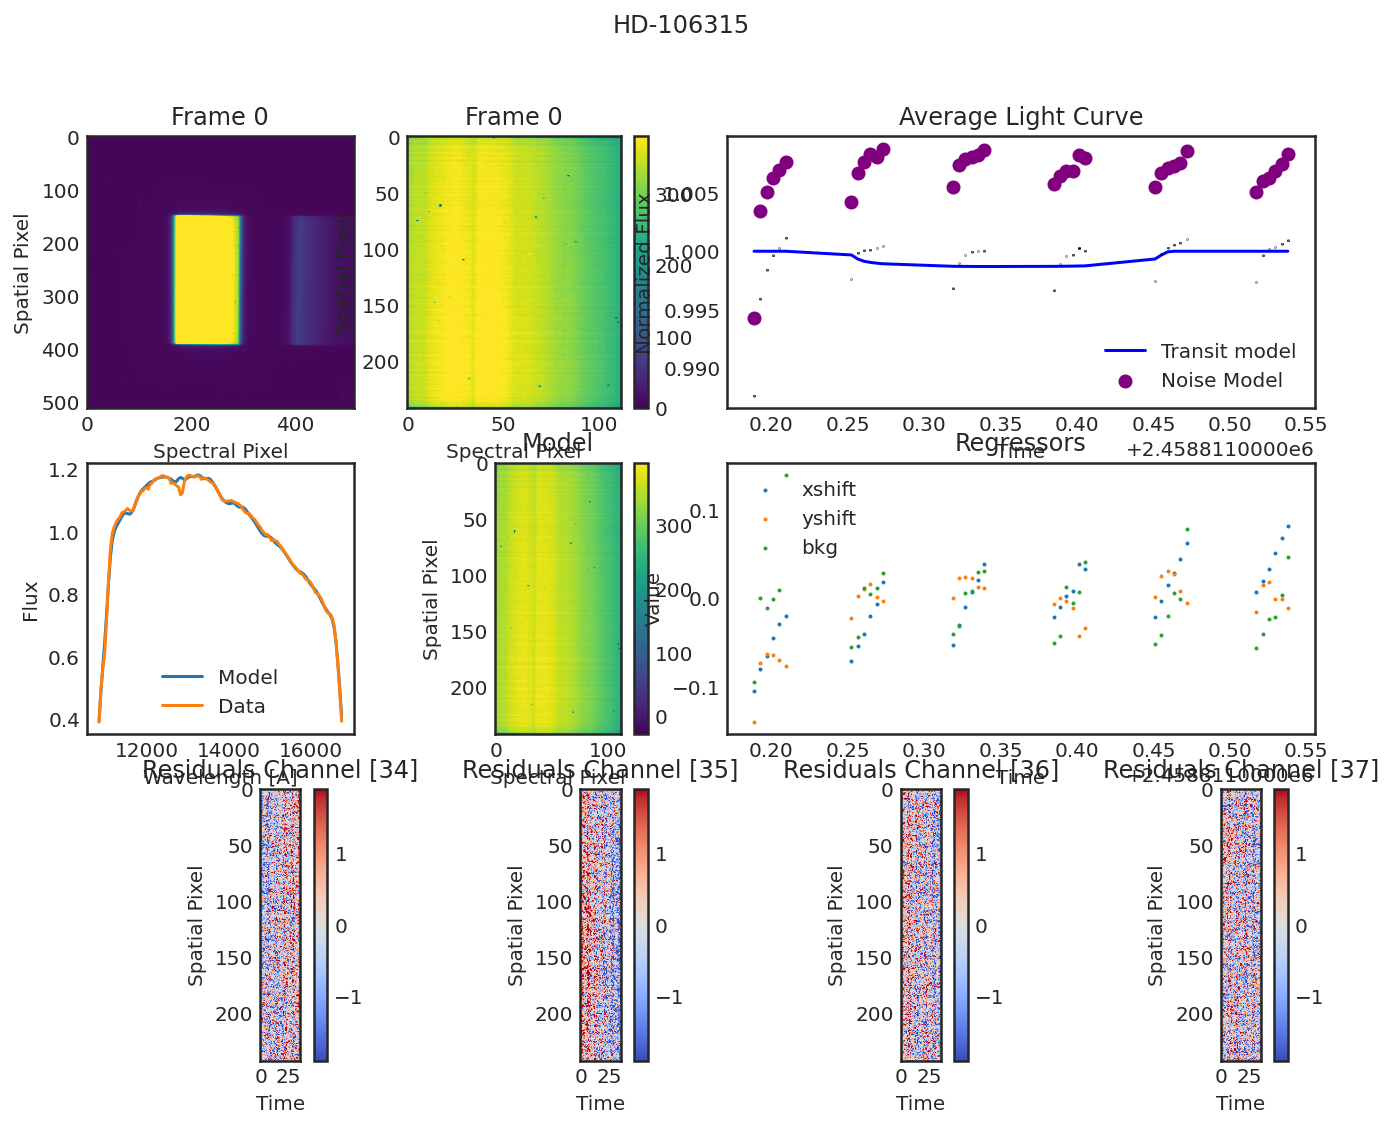

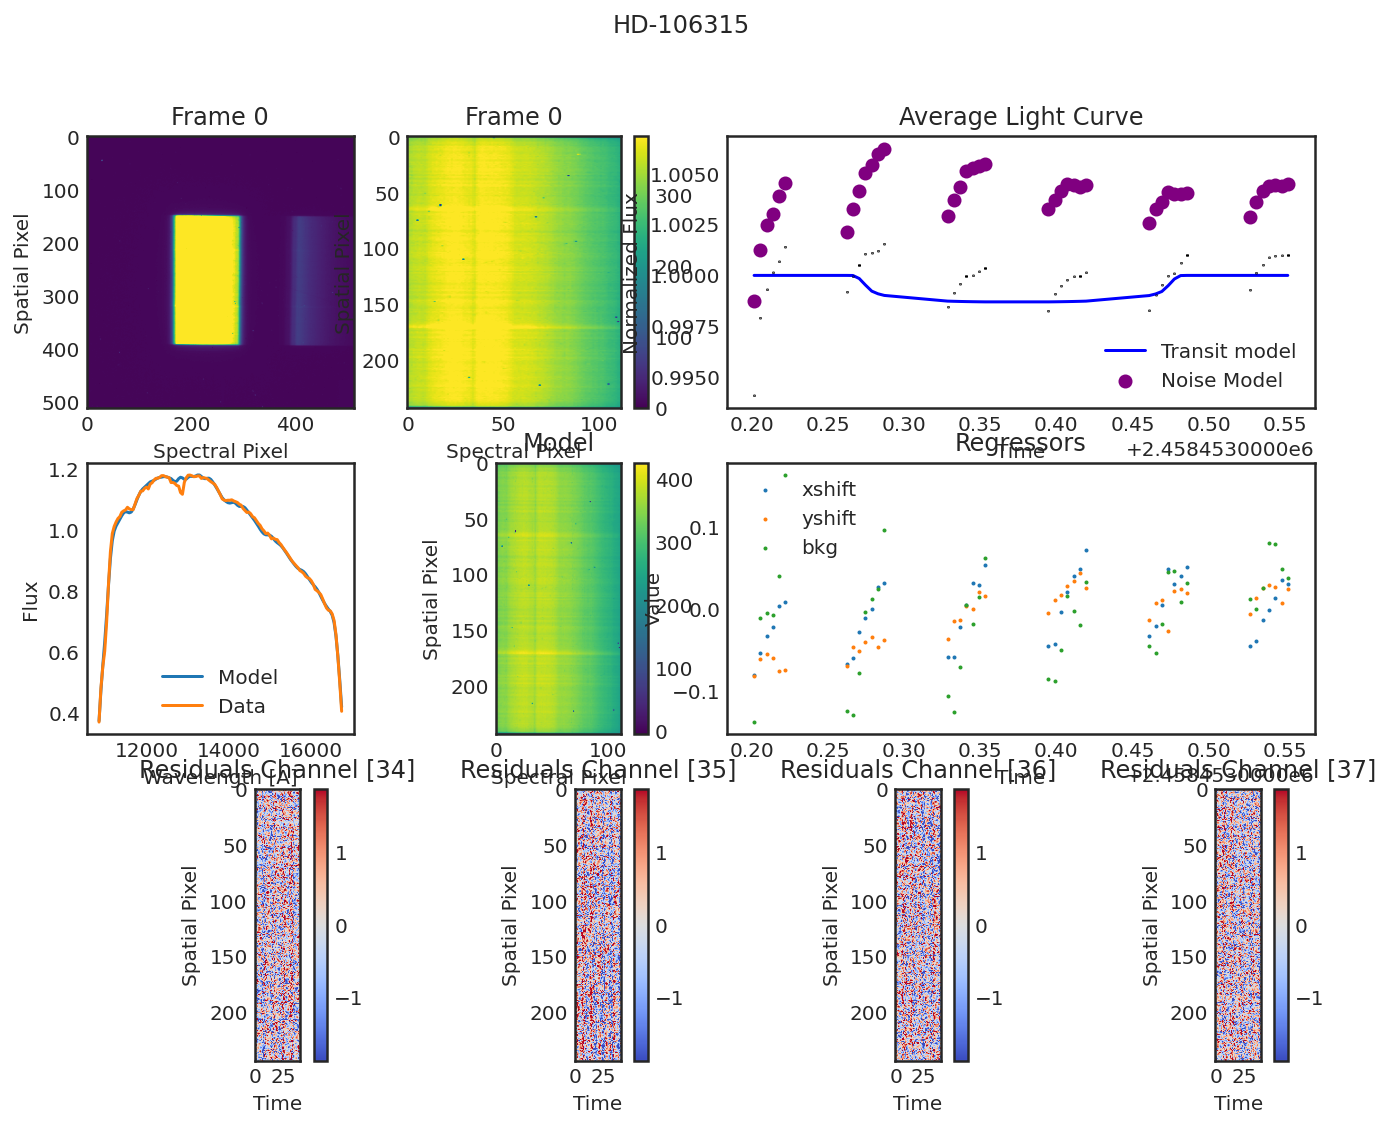

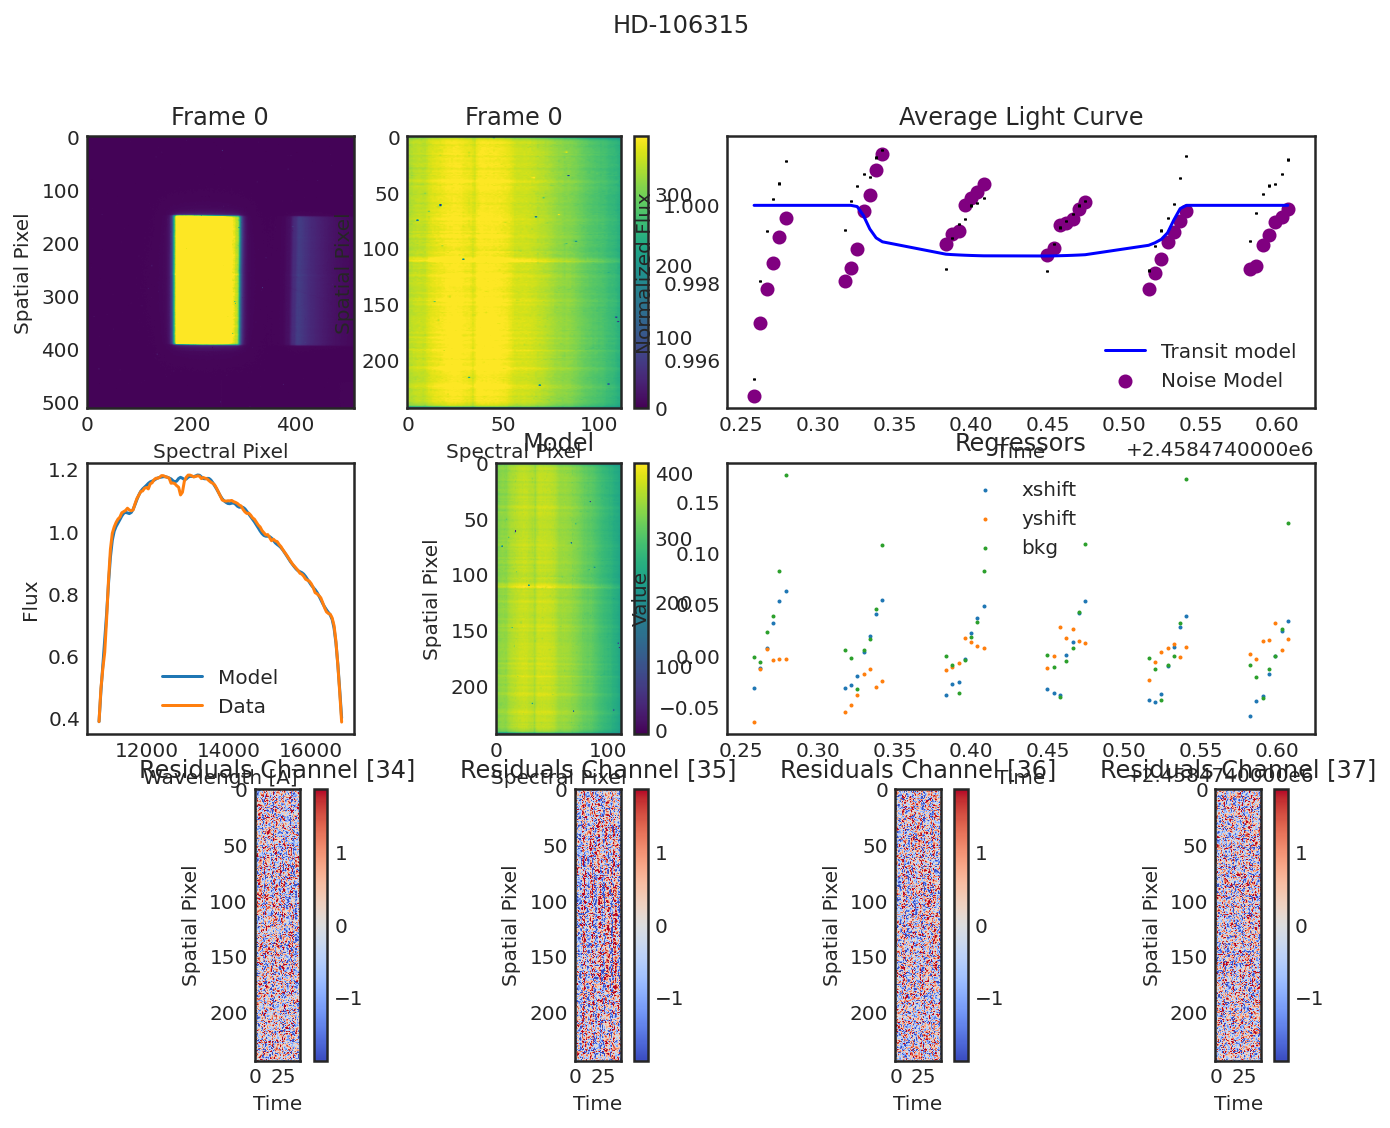

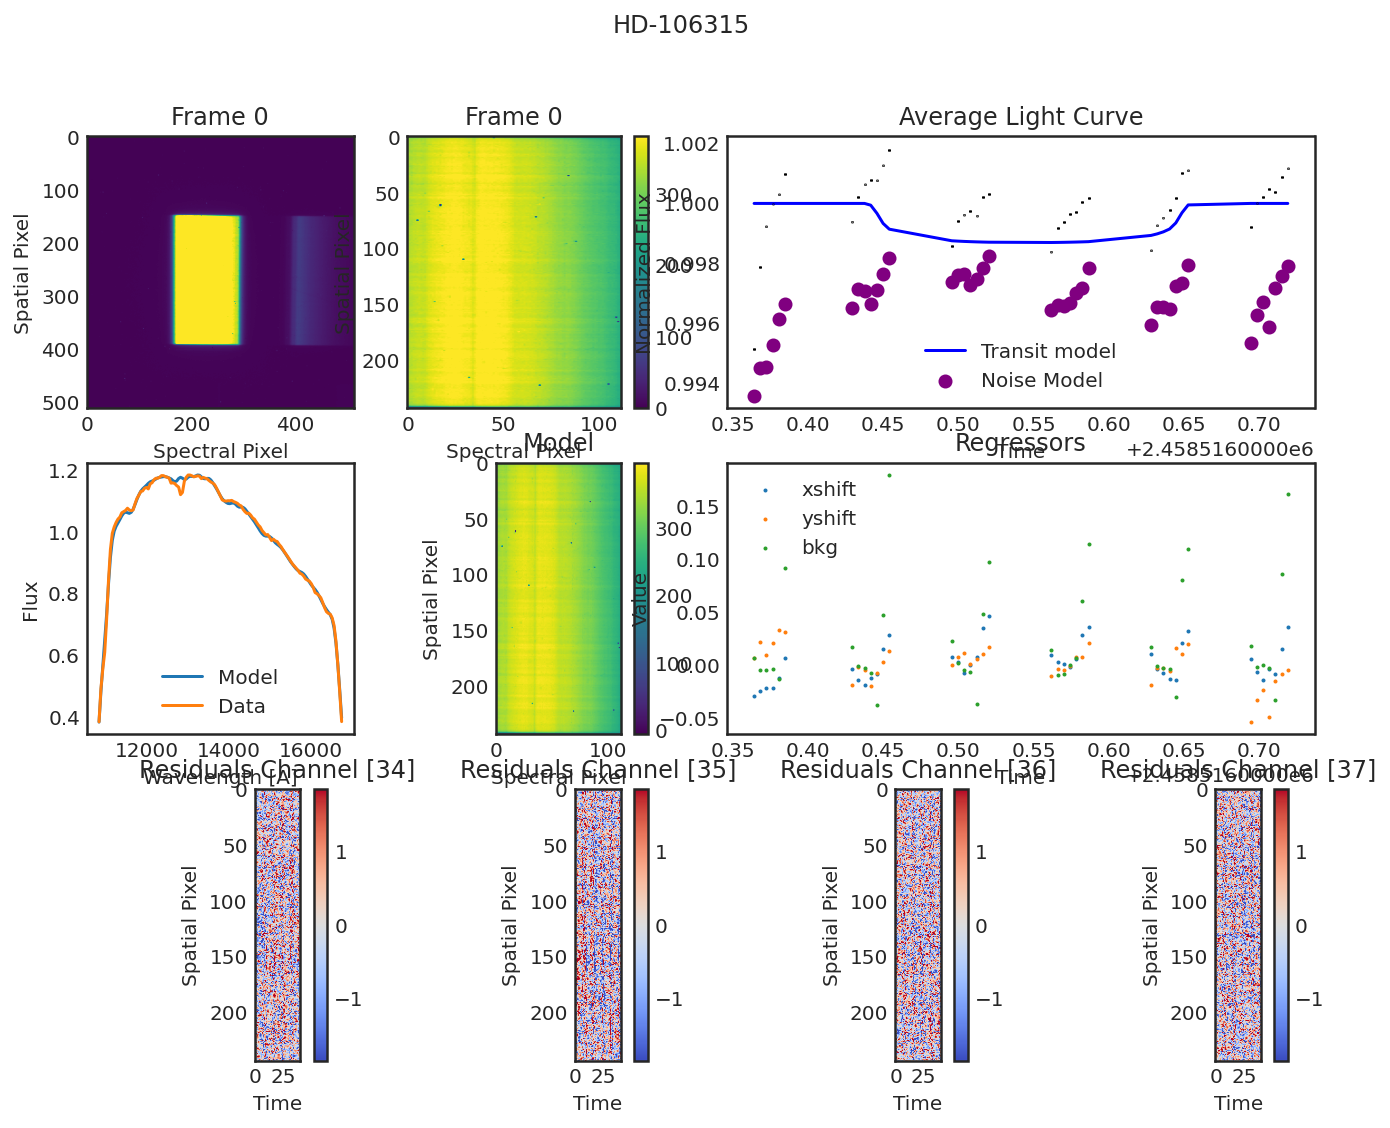

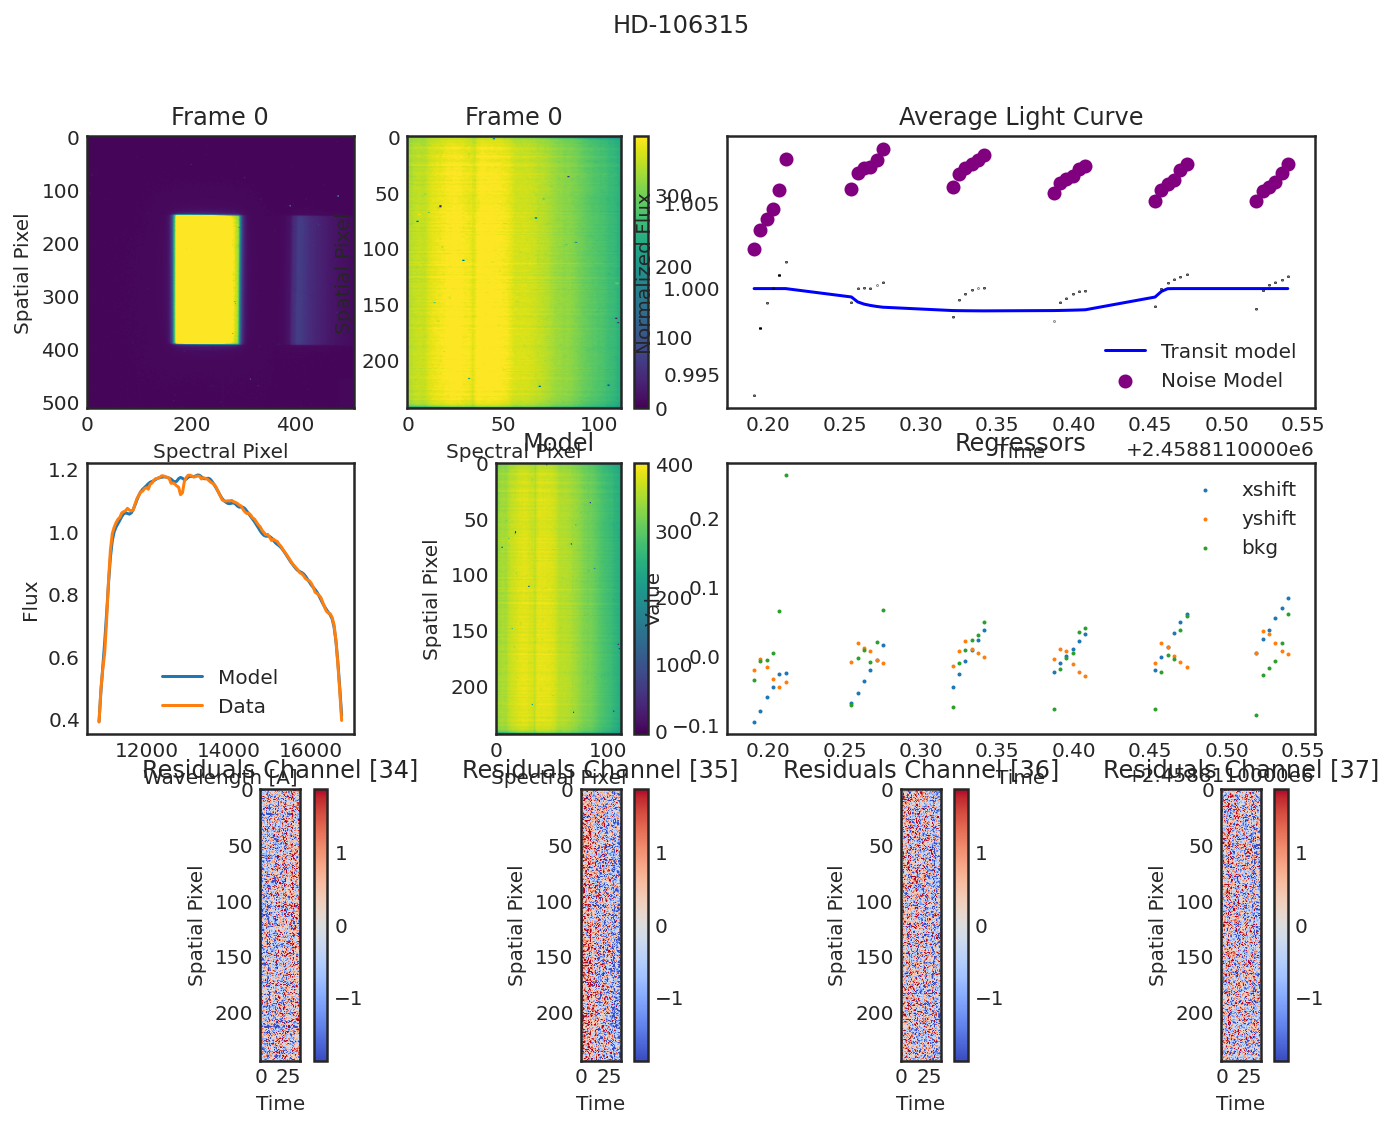

In [30]:
for visit in obs:
    visit.diagnose();
    plt.show();